# 모델1
- Feature
    - **기사제목+댓글 텍스트**
- Label
    - **긍정/부정**


- 학습 방법
    - 시간 관계상, 학습을 위해 직접 긍정/부정 라벨링이 어렵기 때문에 **후보평가**와 **정당 평가** 중 하나도 있는 값을 y로 설정하여 학습시키기
    - Logistic 이용

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns 
import re
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix
import warnings

# 모델 저장
import pickle

# KFold
from sklearn.model_selection import KFold # 순서대로 하거나 or 랜덤하게 클래스를 나눈다.
from sklearn.model_selection import StratifiedKFold # 결과데이터를 보고 각 클래스가 균등한 비율로 들어있게끔 나눈다.

# 교차검증 함수
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

warnings.filterwarnings('ignore')
plt.style.use('seaborn-whitegrid')
plt.rcParams['font.family'] = 'Malgun Gothic'
# plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['font.size'] = 10
plt.rcParams['figure.figsize'] = 10,5
plt.rcParams['axes.unicode_minus'] = False

## 0. 데이터 불러오기

In [144]:
df = pd.read_csv('data/취합_0405_최종.csv')
df

,제목,날짜,작성일,댓글,출처,"지역(서울:1, 부산:2)","정당(1:더불어민주당,2:국민의힘)","정당평가(부정;0, 긍정:1)",후보(기호 순),"후보평가(부정;0, 긍정:1)",제목댓글
0,"[재보궐 D-31] 부산 김영춘 vs 박형준, 서울도 양자 대결?",2021-03-07 05:57:00,2021-03-12 19:13:00,철수야! 뜸 들이지 말고 애국하는 마음으로 물러서라~~~,조선일보,NaN,NaN,NaN,NaN,NaN,"[재보궐 D-31] 부산 김영춘 vs 박형준, 서울도 양자 대결? 철수야! 뜸 들이..."
1,"[재보궐 D-31] 부산 김영춘 vs 박형준, 서울도 양자 대결?",2021-03-07 05:57:00,2021-03-09 13:49:00,박영선은 정동영이 얻은 36프로선에 머무를것. 4.7.이후 OOO정권은 몰락의 길 ...,조선일보,1.0,NaN,NaN,1.0,0.0,"[재보궐 D-31] 부산 김영춘 vs 박형준, 서울도 양자 대결? 박영선은 정동영이..."
2,"[재보궐 D-31] 부산 김영춘 vs 박형준, 서울도 양자 대결?",2021-03-07 05:57:00,2021-03-07 14:42:00,빵선이가서울시장되면서울은공산국가수도제2의평양이될것이다,조선일보,1.0,NaN,NaN,1.0,0.0,"[재보궐 D-31] 부산 김영춘 vs 박형준, 서울도 양자 대결? 빵선이가서울시장되..."
3,"[재보궐 D-31] 부산 김영춘 vs 박형준, 서울도 양자 대결?",2021-03-07 05:57:00,2021-03-07 14:38:00,서울시장후보더듬당박빵선이는절대로서울시장을할수없다이유는가족은미국.영국에 영주권자이므로...,조선일보,1.0,1.0,0.0,1.0,0.0,"[재보궐 D-31] 부산 김영춘 vs 박형준, 서울도 양자 대결? 서울시장후보더듬당..."
4,"[재보궐 D-31] 부산 김영춘 vs 박형준, 서울도 양자 대결?",2021-03-07 05:57:00,2021-03-07 14:02:00,부산은오거돈선거이고 오거돈치부선거아닌가 오거돈에 성추해으로 생긴선거가 가독도신공항은...,조선일보,2.0,1.0,0.0,NaN,NaN,"[재보궐 D-31] 부산 김영춘 vs 박형준, 서울도 양자 대결? 부산은오거돈선거이..."
...,...,...,...,...,...,...,...,...,...,...,...
85674,민주당 “3% 내 박빙 승부” 국민의힘 “15% 이상 이긴다”,2021-04-06 17:40:00,2021-04-06 00:00:00,정부여당이 진짜 싫어서 옛 한나라당 자한당 이 자들에게 다시 맡겨야겠다 말인가?.....,경향신문,NaN,NaN,NaN,NaN,NaN,민주당 “3% 내 박빙 승부” 국민의힘 “15% 이상 이긴다” 정부여당이 진짜 싫어...
85675,민주당 “3% 내 박빙 승부” 국민의힘 “15% 이상 이긴다”,2021-04-06 17:40:00,2021-04-06 00:00:00,@이나라왕 저자들은 왜 후보를 내세웠는가? 성추행을 정당화하는가?\n\n좌빨들이 정...,경향신문,NaN,NaN,NaN,NaN,NaN,민주당 “3% 내 박빙 승부” 국민의힘 “15% 이상 이긴다” @이나라왕 저자들은 ...
85676,민주당 “3% 내 박빙 승부” 국민의힘 “15% 이상 이긴다”,2021-04-06 17:40:00,2021-04-06 00:00:00,@이나라왕 진보가 집권해서 무주택자들의 삶이 파탄이 났는데 더 이상 무슨말이 필요한...,경향신문,NaN,NaN,NaN,NaN,NaN,민주당 “3% 내 박빙 승부” 국민의힘 “15% 이상 이긴다” @이나라왕 진보가 집...
85677,민주당 “3% 내 박빙 승부” 국민의힘 “15% 이상 이긴다”,2021-04-06 17:40:00,2021-04-06 00:00:00,@세상은 해도 않되면 어쩔 수 없겠지만\n애초에 해 볼 수도 없었던 시절의 매국노힘...,경향신문,NaN,NaN,NaN,NaN,NaN,민주당 “3% 내 박빙 승부” 국민의힘 “15% 이상 이긴다” @세상은 해도 않되면...


In [9]:
# 데이터 구조
df.shape

(72682, 11)

In [10]:
# 제목과 댓글은 '제목 댓글 컬럼' 존재로 삭제
# 기사가 작성된 날짜는 삭제
df = df.drop( columns=['제목','날짜','댓글'])
df.head(2)

,작성일,출처,"지역(서울:1, 부산:2)","정당(1:더불어민주당,2:국민의힘)","정당평가(부정;0, 긍정:1)",후보(기호 순),"후보평가(부정;0, 긍정:1)",제목댓글
0,2021-03-12 19:13:00,조선일보,NaN,NaN,NaN,NaN,NaN,"[재보궐 D-31] 부산 김영춘 vs 박형준, 서울도 양자 대결? 철수야! 뜸 들이..."
1,2021-03-09 13:49:00,조선일보,1,NaN,NaN,1.0,0.0,"[재보궐 D-31] 부산 김영춘 vs 박형준, 서울도 양자 대결? 박영선은 정동영이..."


In [11]:
# 컬럼 이름 영어로 변경
cols = ['date','press','area', 'party','party_eval', 
        'candidate','candidate_eval','title_comment']
df.columns = cols
df.head()

,date,press,area,party,party_eval,candidate,candidate_eval,title_comment
0,2021-03-12 19:13:00,조선일보,NaN,NaN,NaN,NaN,NaN,"[재보궐 D-31] 부산 김영춘 vs 박형준, 서울도 양자 대결? 철수야! 뜸 들이..."
1,2021-03-09 13:49:00,조선일보,1,NaN,NaN,1.0,0.0,"[재보궐 D-31] 부산 김영춘 vs 박형준, 서울도 양자 대결? 박영선은 정동영이..."
2,2021-03-07 14:42:00,조선일보,1,NaN,NaN,1.0,0.0,"[재보궐 D-31] 부산 김영춘 vs 박형준, 서울도 양자 대결? 빵선이가서울시장되..."
3,2021-03-07 14:38:00,조선일보,1,1.0,0.0,1.0,0.0,"[재보궐 D-31] 부산 김영춘 vs 박형준, 서울도 양자 대결? 서울시장후보더듬당..."
4,2021-03-07 14:02:00,조선일보,2,1.0,0.0,NaN,NaN,"[재보궐 D-31] 부산 김영춘 vs 박형준, 서울도 양자 대결? 부산은오거돈선거이..."


## 1. Feature-label 
- 정당평가, 후보자평가 둘 중 하나라도 nan이 아니면 값으로 받기
- 텍스트에 대해 직접 긍정/부정 라벨링을 해야하나 시간 관계상, 정당평가나 후보자 평가 중 하나라도 있으면 이를 y값으로 두어 학습시키기

In [12]:
# 둘 중 하나라도 값이 있으면 인덱스 추출

# 값을 담을 리스트
A = []
B =[]
A_B = []

for p, c in zip( df['party_eval'].items(), df['candidate_eval'].items()):
    # 정당평가 有, 후보평가 無
    if (p[1] in [1.0,0.0]) & (c[1] not in [1.0,0.0]):
#         print(p[0], p[1])
        A.append(p[0])
    
    # 정당평가 無, 후보평가 有
    elif (p[1] not in [1.0,0.0]) & ( c[1] in [1.0,0.0]):
#         print(p[1], c[1])
#         print(p[0], c[0])
        B.append(c[0])
    
    # 정당평가 有, 후보평가 有
    elif (p[1] in [1.0,0.0]) & (c[1] in [1.0,0.0]):
#         print(p[1], c[1])
        A_B.append(p[0])
        
print(len(A), len(B), len(A_B))
print( len(A)+len(B)+len(A_B)) # 가용한 총 데이터수

1431 1844 209
3484


In [13]:
# 리스트를 하나로 묶기
index = A+ B + A_B
len(index)

3484

In [14]:
# 둘 중 하나라도 있는 값만을 데이터 프레임으로 형성, 혹시 모를 NaN값 삭제
index2 = df.iloc[index][['party_eval','candidate_eval']].dropna(how='all').index
df2 = df.iloc[index2]
print(df2.shape)

# 인덱스 재배열
df2.reset_index(inplace=True) 

(3484, 8)


In [15]:
df2

,index,date,press,area,party,party_eval,candidate,candidate_eval,title_comment
0,4,2021-03-07 14:02:00,조선일보,2,1.0,0.0,NaN,NaN,"[재보궐 D-31] 부산 김영춘 vs 박형준, 서울도 양자 대결? 부산은오거돈선거이..."
1,5,2021-03-07 13:15:00,조선일보,NaN,1.0,0.0,NaN,NaN,"[재보궐 D-31] 부산 김영춘 vs 박형준, 서울도 양자 대결? 일단 일자리와 경..."
2,11,2021-03-07 09:50:00,조선일보,NaN,1.0,0.0,NaN,NaN,"[재보궐 D-31] 부산 김영춘 vs 박형준, 서울도 양자 대결? 수십조 세금을 평..."
3,19,2021-03-07 08:23:00,조선일보,1,1.0,0.0,NaN,NaN,"[재보궐 D-31] 부산 김영춘 vs 박형준, 서울도 양자 대결? 박원순의 성폭력 ..."
4,21,2021-03-07 08:21:00,조선일보,NaN,1.0,1.0,NaN,NaN,"[재보궐 D-31] 부산 김영춘 vs 박형준, 서울도 양자 대결? 이번 보궐선거는 ..."
...,...,...,...,...,...,...,...,...,...
3479,72586,2021-03-26 00:00:00,유튜브,0.0,2.0,0.0,2.0,0.0,"""내곡동 땅"" vs ""보궐선거 원인""…첫 TV 토론 어땠나 / SBS / 주영진의 ..."
3480,72613,2021-03-26 00:00:00,유튜브,2.0,2.0,0.0,2.0,0.0,"""내곡동 땅"" vs ""보궐선거 원인""…첫 TV 토론 어땠나 / SBS / 주영진의 ..."
3481,72629,2021-03-25 00:00:00,유튜브,2.0,2.0,0.0,2.0,0.0,‘내곡동 땅 의혹’ 공방…오늘밤 서울시장 후보 TV토론 / KBS 2021.03.3...
3482,72642,2021-03-27 00:00:00,유튜브,2.0,2.0,0.0,2.0,0.0,"[뉴스큐] 서울시장 후보 박영선·오세훈, 오늘 밤 첫 TV 토론 / YTN솔직히 오..."


In [16]:
# X-y값으로 나누기
X = df2['title_comment']

# 후보자 평가 nan값을 정당 평가로 채우기
y = df2['candidate_eval'].fillna( df2['party_eval'] )

In [17]:
# X-y값 구조 확인
y.shape, X.shape

((3484,), (3484,))

In [18]:
# Null값 확인
X.isna().sum()
print(X.isna().sum(), y.isna().sum())

0 0


## 2. 학습시킬 라벨의 긍정/부정 확인

In [19]:
# y값의 종류 확인
y.value_counts()

0.0    2667
1.0     817
Name: candidate_eval, dtype: int64

## 3. Logistic 모델 사용
- (1) 형태소 분석
- (2) CounterVectorize
    - 참고 자료: https://wiserloner.tistory.com/917
- (3) TF-IDF
- (4) 분류모델 학습
- (5) 평가
- (6) 모델저장
- (7) 모델불러오기
- (8) 추정 확률 알아보기

In [20]:
# 위에서 분류했던 X,y 합치기
df3 = pd.concat([X,y], axis=1)

# 컬럼 이름 변경
df3 = df3.rename( columns={'candidate_eval': 'y'} )

df3.shape

(3484, 2)

In [21]:
# 감성분석에 필요할 데이터를 csv로 저장
# df3.to_csv('data/setiment_analysis_data.csv')

In [22]:
# 정규식
def text_cleaning(text) :
    hangul = re.compile('[^ ㄱ-ㅣ가-힣]+')
    result = hangul.sub('', text)
    return result

In [23]:
# 한글 외 문자는 제거
df3['title_comment'] = df3['title_comment'].apply( lambda x: text_cleaning(x) )

In [24]:
df3

,title_comment,y
0,재보궐 부산 김영춘 박형준 서울도 양자 대결 부산은오거돈선거이고 오거돈치부선거아...,0.0
1,재보궐 부산 김영춘 박형준 서울도 양자 대결 일단 일자리와 경제를 말아드신 여당...,0.0
2,재보궐 부산 김영춘 박형준 서울도 양자 대결 수십조 세금을 평가순위 위인 가덕도...,0.0
3,재보궐 부산 김영춘 박형준 서울도 양자 대결 박원순의 성폭력 자살을 공수처에 수...,0.0
4,재보궐 부산 김영춘 박형준 서울도 양자 대결 이번 보궐선거는 임기가 년남짓이다 ...,1.0
...,...,...
3479,내곡동 땅 보궐선거 원인첫 토론 어땠나 주영진의 뉴스브리핑오세훈 무료급식 ...,0.0
3480,내곡동 땅 보궐선거 원인첫 토론 어땠나 주영진의 뉴스브리핑국민은 알고 있다...,0.0
3481,내곡동 땅 의혹 공방오늘밤 서울시장 후보 토론 국민은 알고 있다 국민의 짐 정...,0.0
3482,뉴스큐 서울시장 후보 박영선오세훈 오늘 밤 첫 토론 솔직히 오세훈과 박형준은 내...,0.0


### (1) 형태소 구분

In [25]:
# 형태소 분류 태그
from konlpy.tag import Okt

In [26]:
def get_pos(x) :
    tagger = Okt() # Okt로 형태소 분리하기
    pos = tagger.pos(x) 
    results = [] # 형태소를 담을 리스트
    for i in pos:
        if i[1] != 'Josa': # 조사는 빼버리기
            results.append(f'{i[0]}/{i[1]}') #'단어/품사'의 형태로 리스트에 추가
        else:
            pass
    return results

In [27]:
# 제목_댓글의 첫번째 데이터만 가져와서 형태소 분리
print(get_pos(df3['title_comment'][0]))

['재보궐/Noun', '부산/Noun', '김영춘/Noun', '박형준/Noun', '서울/Noun', '양자/Noun', '대결/Noun', '부산/Noun', '오거돈/Noun', '선거/Noun', '오거돈/Noun', '치부/Noun', '선거/Noun', '아닌가/Adjective', '오거돈/Noun', '성/Noun', '추해으로/Adjective', '생긴/Verb', '선거/Noun', '가독/Noun', '신/Modifier', '공항/Noun', '오거돈/Noun', '재산/Noun', '불려줄려고/Verb', '문재인/Noun', '민주당/Noun', '들/Suffix', '발악/Noun', '아닌가다/Adjective', '부산/Noun', '사람/Noun', '하는말/Verb', '이번/Noun', '선거/Noun', '쎄/Adjective', '빠지게/Verb', '오거돈/Noun', '위/Noun', '선가아이가다/Verb']


### ※ (참고) 단어 빈도 세기

In [28]:
from collections import Counter

# 글 내용을 형태소 분리한 결과를 가져온다.
pos_list = df3['title_comment'].apply(lambda x : get_pos(x))

pos_list2 = pos_list.tolist()
# 2차원으로 구성되어 있는 문자열 리스트내의 모든 문자열을
# 다 추출해 하나의 문자열 리스트로 생성한다.
corpus = sum(pos_list2, [])

In [29]:
# Counter를 생성한다.
counter = Counter(corpus)

In [30]:
# 상위 50개 를 가져온다.
a1 = counter.most_common(50)
a1

[('박영선/Noun', 2004),
 ('들/Suffix', 1991),
 ('오세훈/Noun', 1818),
 ('서울시장/Noun', 1221),
 ('민주당/Noun', 1180),
 ('국민/Noun', 1109),
 ('후보/Noun', 1107),
 ('보궐선거/Noun', 877),
 ('선거/Noun', 836),
 ('것/Noun', 816),
 ('토론/Noun', 760),
 ('더불어/Verb', 670),
 ('하는/Verb', 584),
 ('부산/Noun', 570),
 ('안철수/Noun', 562),
 ('문재인/Noun', 549),
 ('땅/Noun', 538),
 ('뉴스/Noun', 509),
 ('이/Determiner', 502),
 ('내곡동/Noun', 496),
 ('서울/Noun', 488),
 ('브리핑/Noun', 436),
 ('당/Suffix', 434),
 ('주영진/Noun', 433),
 ('정권/Noun', 417),
 ('말/Noun', 407),
 ('적/Suffix', 398),
 ('야당/Noun', 392),
 ('힘/Noun', 391),
 ('사람/Noun', 385),
 ('박형준/Noun', 380),
 ('장/Suffix', 369),
 ('할/Verb', 369),
 ('후보자/Noun', 365),
 ('시민/Noun', 360),
 ('토론회/Noun', 352),
 ('윤석열/Noun', 342),
 ('시장/Noun', 336),
 ('부산시/Noun', 330),
 ('첫/Noun', 326),
 ('가덕도/Noun', 323),
 ('원인/Noun', 322),
 ('이/Noun', 307),
 ('다/Adverb', 306),
 ('어땠나/Adjective', 302),
 ('한/Determiner', 296),
 ('한다/Verb', 291),
 ('못/VerbPrefix', 282),
 ('당신/Noun', 281),
 ('분/Noun', 279)]

### (2) 학습데이터 구분
- CounterVectorize: Convert a collection of text documents to **a matrix of token counts**
- 단어들의 **카운트(출현 빈도(frequency))**로 여러 문서들을 **벡터화**
- 카운트 행렬, 단어 문서 행렬 (Term-Document Matrix, TDM))
- 모두 소문자로 변환시키기 때문에 me 와 Me 는 모두 같은 특성이 된다.

In [31]:
# 단어당 몇개씩 들어 있는지에 대한 벡터를 생성
from sklearn.feature_extraction.text import CountVectorizer

index_vectorizer = CountVectorizer(tokenizer= lambda x : get_pos(x))
X = index_vectorizer.fit_transform(df3['title_comment'].tolist())

In [26]:
# { 단어: 단어 인덱스 } 형태의 사전 확인
# index_vectorizer.vocabulary_

In [27]:
# 실제 형태소
print(get_pos(df3['title_comment'][0]))

# 결과
print( X[0]) # ( 문장 순서, 단어 인덱스)    등장 횟수

['재보궐/Noun', '부산/Noun', '김영춘/Noun', '박형준/Noun', '서울/Noun', '양자/Noun', '대결/Noun', '부산/Noun', '오거돈/Noun', '선거/Noun', '오거돈/Noun', '치부/Noun', '선거/Noun', '아닌가/Adjective', '오거돈/Noun', '성/Noun', '추해으로/Adjective', '생긴/Verb', '선거/Noun', '가독/Noun', '신/Modifier', '공항/Noun', '오거돈/Noun', '재산/Noun', '불려줄려고/Verb', '문재인/Noun', '민주당/Noun', '들/Suffix', '발악/Noun', '아닌가다/Adjective', '부산/Noun', '사람/Noun', '하는말/Verb', '이번/Noun', '선거/Noun', '쎄/Adjective', '빠지게/Verb', '오거돈/Noun', '위/Noun', '선가아이가다/Verb']
  (0, 12742)	1
  (0, 7437)	3
  (0, 1865)	1
  (0, 6577)	1
  (0, 8496)	1
  (0, 10305)	1
  (0, 3536)	1
  (0, 10962)	5
  (0, 8530)	4
  (0, 14872)	1
  (0, 9658)	1
  (0, 8629)	1
  (0, 14732)	1
  (0, 8433)	1
  (0, 137)	1
  (0, 9186)	1
  (0, 1141)	1
  (0, 12745)	1
  (0, 7602)	1
  (0, 6104)	1
  (0, 6316)	1
  (0, 4452)	1
  (0, 6706)	1
  (0, 9659)	1
  (0, 8109)	1
  (0, 15770)	1
  (0, 11842)	1
  (0, 9459)	1
  (0, 7851)	1
  (0, 11464)	1
  (0, 8529)	1


### (3) TF-IDF로 변환
- Tf(Term-Frequency) : 특정 단어가 하나의 데이터 안에서 등장하는 횟수
- Tf-Idf(Term-Freuquency times Inverse Documnet-Frquency) : 특정 단어가 여러 데이터에 자주 등장하는지를 알려주는 지표.

- 사용 목적
    - **Transform**
        - 단어 빈도 매트릭스를 정규화된 tf 또는 tf-idf로 나타내기 위해
    - **Sclae Down**
        - 형태소에서 매우 빈번하게 나타나 경험적으로 덜 유익한 토큰의 영향을 줄이기 위해 사용한다. 

아예 등장하지 않는다면 0, 그 이외에는 실수값이 크다면 그 단어가 보다 가치있는 특징이라는 것이고, 작다면 그다지 가치가 없다고 판단 가능

In [28]:
# 위에서 만든 형태소 벡터를 학습 데이터 벡터로 생성
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_vectorizer = TfidfTransformer()
X = tfidf_vectorizer.fit_transform(X)
print(X[0]) # (문장 번호, 단어 인덱스)    단어의 비중

  (0, 15770)	0.20202340896780419
  (0, 14872)	0.1757982638846172
  (0, 14732)	0.20202340896780419
  (0, 12745)	0.13902606034364695
  (0, 12742)	0.13510395661135768
  (0, 11842)	0.09639720572190877
  (0, 11464)	0.10010079601811227
  (0, 10962)	0.529668058471126
  (0, 10305)	0.14705804151923843
  (0, 9659)	0.20202340896780419
  (0, 9658)	0.11715314154450297
  (0, 9459)	0.20202340896780419
  (0, 9186)	0.10509594133253032
  (0, 8629)	0.1636042658439493
  (0, 8530)	0.25236521076971696
  (0, 8529)	0.20202340896780419
  (0, 8496)	0.07466765765871669
  (0, 8433)	0.1636042658439493
  (0, 8109)	0.08094785838398169
  (0, 7851)	0.20202340896780419
  (0, 7602)	0.20202340896780419
  (0, 7437)	0.22735908863624688
  (0, 6706)	0.1482824717399662
  (0, 6577)	0.08265366644498374
  (0, 6316)	0.05507450512115253
  (0, 6104)	0.07584671981552807
  (0, 4452)	0.050756054797153734
  (0, 3536)	0.13659638979219885
  (0, 1865)	0.11223921509123101
  (0, 1141)	0.10043701503793169
  (0, 137)	0.19234448820932806


### ※ (주의) tfidf_vectorizer도 저장해야한다.
- TfidTransformer를 새롭게 생성한 후 저장한 모델을 사용하면 안 된다.
- "학습 단계에서 생성해서 학습을 시킨 녀석을 그대로 사용해야 합니다. 그녀석도 파일로 저장해 두었다가 사용할 때 불러와서 써야 합니다"


In [29]:
# TF-IDF 저장
with open('model/tfidf_vectorizer_0405.dat','wb') as fp:
    pickle.dump(tfidf_vectorizer, fp)
print('저장완료')

저장완료


### (4) 학습

In [30]:
# 학습-테스트용으로 나누기
from sklearn.model_selection import train_test_split

# 결과값
y = df3['y'] 
X_train, X_test, y_train, y_test = train_test_split( X, y,
                                                    test_size=0.3, 
                                                    stratify=y )

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2438, 16928), (1046, 16928), (2438,), (1046,))

In [31]:
# 로지스틱회귀로 분류분석 진행하기
from sklearn.linear_model import LogisticRegression

# 교차검증: 결과데이터를 보고 각 클래스가 균등한 비율로 들어있게끔 나눈다.
from sklearn.model_selection import StratifiedKFold 

# 평가 방법
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score 
from sklearn.metrics import recall_score 
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

In [32]:
# 교차검증
fold1 = StratifiedKFold( n_splits=10 )

# 로지스틱 회귀 모델 생성
lr = LogisticRegression()

# 최적 파라미터 찾기
params = {'penalty': ['l1', 'l2', 'elasticnet', 'none'],
          'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
          'C':[0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]}

grid_model = GridSearchCV( lr, params, scoring='accuracy', cv=fold1 )

In [33]:
grid_model.fit( X_train,y_train )
print(f'최적의 하이퍼 파라미터: {grid_model.best_params_}')
print(f'최적의 모델 평균 성능: {grid_model.best_score_}')

최적의 하이퍼 파라미터: {'C': 10000, 'penalty': 'l2', 'solver': 'newton-cg'}
최적의 모델 평균 성능: 0.913870336639007


### (5) 평가

In [34]:
# 최고 성능 모델
best_model = grid_model.best_estimator_

#### [1] 학습 데이터의 교차검증

In [35]:
from sklearn.metrics import accuracy_score,f1_score, precision_score, recall_score, roc_auc_score 

# 훈련용 데이터의 교차검증
accuracy = cross_val_score( best_model, X_train, y_train, scoring='accuracy', cv=fold1 )
precision = cross_val_score( best_model, X_train, y_train, scoring='precision', cv=fold1 )
recall_score = cross_val_score( best_model, X_train, y_train, scoring='recall', cv=fold1 )
f1_score = cross_val_score( best_model, X_train, y_train, scoring='f1', cv=fold1 )
roc_auc_score = cross_val_score( best_model, X_train, y_train, scoring='roc_auc', cv=fold1 )

In [36]:
print('평균 정확도', accuracy.mean() )
print('평균 정밀도', precision.mean() )
print('평균 재현율', recall_score.mean() )
print('평균 f1', f1_score.mean() )
print('평균 roc-acu', roc_auc_score.mean() )

평균 정확도 0.913870336639007
평균 정밀도 0.8884148858250681
평균 재현율 0.7236842105263158
평균 f1 0.7963997912380275
평균 roc-acu 0.9373945549643006


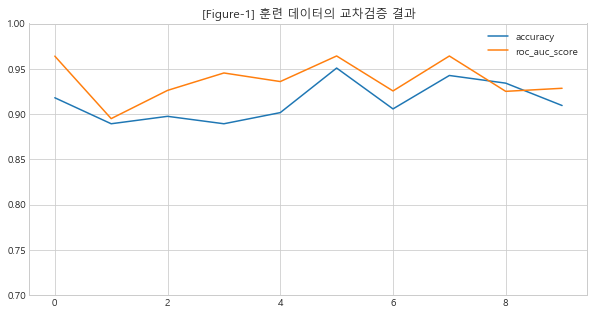

In [37]:
plt.plot( accuracy , label='accuracy')
# plt.plot( precision , label='precision')
# plt.plot( recall_score , label='recall_score')
# plt.plot( f1_score , label='f1_score')
plt.ylim(0.7, 1.0)
plt.plot( roc_auc_score , label='roc_auc_score')
plt.legend()
plt.title( '[Figure-1] 훈련 데이터의 교차검증 결과')
plt.show()

#### [2]  테스트 데이터 검증

In [38]:
# 테스트용 데이터를 통해 예측하기
y_pred = best_model.predict(X_test)

# 테스트 데이터 정확도
result = accuracy_score( y_test, y_pred ) 
result # 정확도

0.887189292543021

### (6) 모델 저장

In [39]:
with open('model/pos_neg_logi_model_0405.dat','wb') as fp:
    pickle.dump(best_model, fp)
print('저장완료')

저장완료


### (7) 모델 불러오기

In [96]:
with open('model/pos_neg_logi_model_0405.dat', 'rb') as fp:
    new_model = pickle.load(fp)
print('출력 완료')

출력 완료


### (8) 추정 확률 알아보기

In [41]:
# 클래스 순서에 따른 추정 확률 [ 0일 확률, 1일 확률 ]
proba = new_model.predict_proba( X_test )
proba

array([[8.44721109e-01, 1.55278891e-01],
       [5.39280984e-01, 4.60719016e-01],
       [9.99991687e-01, 8.31310565e-06],
       ...,
       [9.95870758e-01, 4.12924179e-03],
       [9.99782910e-01, 2.17089952e-04],
       [9.99998267e-01, 1.73281574e-06]])

In [42]:
# 각 값에 대한 추정 확률과 실제 값을 데이터 프레임으로 형성
proba_df = pd.DataFrame(proba)
proba_df['target'] = new_model.predict(X_test)
proba_df

,0,1,target
0,0.844721,1.552789e-01,0.0
1,0.539281,4.607190e-01,0.0
2,0.999992,8.313106e-06,0.0
3,1.000000,3.039969e-07,0.0
4,0.999908,9.231045e-05,0.0
...,...,...,...
1041,0.999932,6.768908e-05,0.0
1042,0.999836,1.640038e-04,0.0
1043,0.995871,4.129242e-03,0.0
1044,0.999783,2.170900e-04,0.0


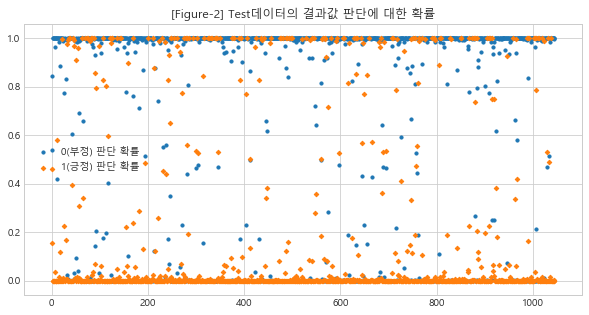

In [43]:
plt.scatter( range(len(proba_df[0])), proba_df[0] , label='0(부정) 판단 확률',s=10)
plt.scatter( range(len(proba_df[1])), proba_df[1] , label='1(긍정) 판단 확률',marker='D', s=10)
plt.legend()
plt.title( '[Figure-2] Test데이터의 결과값 판단에 대한 확률')
plt.show()

### ※ CounterVectorizer는 생성한 후 fit 시키지 않고 transform
- **NOT** fit_transform 

### ※ Tf-Idf는 학습할 때 사용한 Tf-Idf를 사용해야 한다.

In [44]:
# **저장한 tf-idf 벡터라이저 사용**
with open('model/tfidf_vectorizer_0405.dat', 'rb') as fp:
    new_tfidf_vectorizer = pickle.load(fp)
print('출력 완료')

출력 완료


In [45]:
# 2. 임의의 텍스트로 예측
test = [
    '박영선 아웃',
    '오세훈은 뭐냐? 무상급식 기억 안 나냐?',
    '더불어 만진당에서 나온 후보라..',
    '국민의 짐',
    '성추행당은 꺼져라',
    '오세훈 후보 지지합니다',
    '참나',
    '노답',
    '누굴 뽑으라는거야',
    '둘다 별로야'
]

# CounterVectorrizer는 다시 fit시키는 것이 아니라 transform만 시키는 것
X = index_vectorizer.transform(test)

# tf-idf는 새로 생성하는 것이 아니라 학습시킨 td-idf를 저장하여 사용하는 것
X = new_tfidf_vectorizer.transform(X)

y_pred = new_model.predict(X)
y_pred

array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.])

## 5. 후보자의 이름이나, 정당의 이름이 들어갈 경우 ?

In [46]:
test2 = [
    '박영선',
    '오세훈',
    '김영춘',
    '박형준',
    '더불어 민주당',
    '국민의 힘',
]

# CounterVectorizer & Tf-Idf
X = index_vectorizer.transform(test2)
X = new_tfidf_vectorizer.transform(X)

# 긍정/부정 예측 결과
new_model.predict(X)

array([0., 1., 0., 0., 0., 0.])

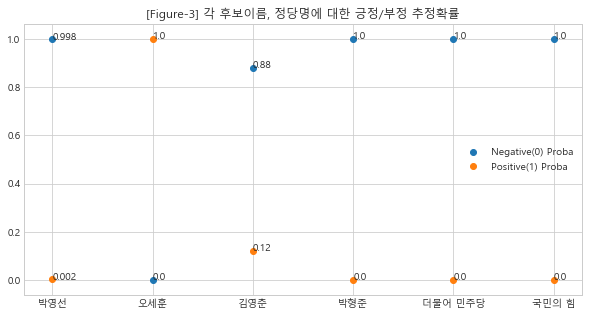

In [47]:
# 추정 확률 알아보기
proba_0 = new_model.predict_proba(X)[:,0]
proba_1 = new_model.predict_proba(X)[:,1]

plt.scatter( test2, proba_0 , label='Negative(0) Proba')
plt.scatter( test2, proba_1 , label='Positive(1) Proba')

for idx, val in zip(test2, proba_0):
    plt.text(idx, val, f'{round(val,3)}' )    
for idx, val in zip(test2, proba_1):
    plt.text(idx, val, f'{round(val,3)}' )    
plt.title('[Figure-3] 각 후보이름, 정당명에 대한 긍정/부정 추정확률')
plt.legend()
plt.show()

- 위 모델은 **여당**과 **여당의 후보**가 글에 포함될 경우 **부정**으로 판단함을 알 수 있음
    - 보수 언론의 데이터가 많아서 이러한 도출 되었거나
    - 실제 여론을 반영한 결과라고 해석할 수 있다.
- 기존 모델과 차이점은 박형준 후보 역시 부정적으로 평가한다는 것

## 6. 새로운 모델 형성
- 후보이름, 당명에 따라 긍정/부정이 명확히 구분되는 특징을 보임
- 후보이름(4), 당명(2) 6개의 텍스트를 제외한 후 새로운 감성분석 모델 형성

In [56]:
# copy
df4 = df3.copy()

# 후보이름, 당명을 대체
df4['title_comment'] = df4['title_comment'].str.replace('박영선|오세훈|김영춘|박형준|영선|세훈|형준|영춘|5세훈', '후보')
df4['title_comment'] = df4['title_comment'].str.replace('더불어민주당|국민의힘|더불어 민주당|국민의 힘|국힘|더불어|민주당', '정당')
df4

,title_comment,y
0,재보궐 부산 후보 후보 서울도 양자 대결 부산은오거돈선거이고 오거돈치부선거아닌가...,0.0
1,재보궐 부산 후보 후보 서울도 양자 대결 일단 일자리와 경제를 말아드신 여당 빼...,0.0
2,재보궐 부산 후보 후보 서울도 양자 대결 수십조 세금을 평가순위 위인 가덕도에 ...,0.0
3,재보궐 부산 후보 후보 서울도 양자 대결 박원순의 성폭력 자살을 공수처에 수사의...,0.0
4,재보궐 부산 후보 후보 서울도 양자 대결 이번 보궐선거는 임기가 년남짓이다 내년...,1.0
...,...,...
3479,내곡동 땅 보궐선거 원인첫 토론 어땠나 주영진의 뉴스브리핑후보 무료급식 못...,0.0
3480,내곡동 땅 보궐선거 원인첫 토론 어땠나 주영진의 뉴스브리핑국민은 알고 있다...,0.0
3481,내곡동 땅 의혹 공방오늘밤 서울시장 후보 토론 국민은 알고 있다 국민의 짐 정...,0.0
3482,뉴스큐 서울시장 후보 후보후보 오늘 밤 첫 토론 솔직히 후보과 후보은 내곡동 ...,0.0


In [57]:
# 단어당 몇개씩 들어 있는지에 대한 벡터를 생성
from sklearn.feature_extraction.text import CountVectorizer

index_vectorizer2 = CountVectorizer(tokenizer= lambda x : get_pos(x))
X = index_vectorizer2.fit_transform(df4['title_comment'].tolist())

In [50]:
# tf-idf로 변환
tfidf_vectorizer2 = TfidfTransformer()
X = tfidf_vectorizer2.fit_transform(X)

In [51]:
# TF-IDF 저장
with open('model/tfidf_vectorizer2_0405.dat','wb') as fp:
    pickle.dump(tfidf_vectorizer2, fp)
print('저장완료')

저장완료


In [52]:
# 학습-테스트용으로 나누기
from sklearn.model_selection import train_test_split

# 결과값
y = df4['y'] 
X_train, X_test, y_train, y_test = train_test_split( X, y,
                                                    test_size=0.3, 
                                                    stratify=y )

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2438, 16897), (1046, 16897), (2438,), (1046,))

In [53]:
# 로지스틱회귀로 분류분석 진행하기
from sklearn.linear_model import LogisticRegression

# 교차검증: 결과데이터를 보고 각 클래스가 균등한 비율로 들어있게끔 나눈다.
from sklearn.model_selection import StratifiedKFold 

# 평가 방법
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score 
from sklearn.metrics import recall_score 
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

In [54]:
# 교차검증
fold1 = StratifiedKFold( n_splits=10 )

# 로지스틱 회귀 모델 생성
lr = LogisticRegression()

# 최적 파라미터 찾기
params = {'penalty': ['l1', 'l2', 'elasticnet', 'none'],
          'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
          'C':[0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]}

grid_model2 = GridSearchCV( lr, params, scoring='accuracy', cv=fold1 )

In [55]:
grid_model2.fit( X_train,y_train )
print(f'최적의 하이퍼 파라미터: {grid_model2.best_params_}')
print(f'최적의 모델 평균 성능: {grid_model2.best_score_}')

최적의 하이퍼 파라미터: {'C': 100, 'penalty': 'none', 'solver': 'sag'}
최적의 모델 평균 성능: 0.8917324428253389


In [56]:
# 테스트 데이터로 예측결과 파악하기
y_pred = grid_model2.best_estimator_.predict(X_test)
accuracy_score(y_test, y_pred)

0.8996175908221797

In [57]:
test2 = [
    '오세훈 후보 화이팅',
    '국짐당은 물러나라',
    '더불어성추행당',
    '참 뽑을 사람 없다.',
    '그 나물에 그 밥',
    '양심이 있냐',
    '정신차려라'
]

# CounterVectorizer & Tf-Idf
X = index_vectorizer2.transform(test2)
X = tfidf_vectorizer2.transform(X)

# 긍정/부정 예측 결과
grid_model2.best_estimator_.predict(X)

array([1., 0., 0., 0., 1., 0., 0.])

In [58]:
grid_model2.best_estimator_.predict_proba(X)

array([[2.64150923e-11, 1.00000000e+00],
       [9.98738160e-01, 1.26183972e-03],
       [9.99999901e-01, 9.92267845e-08],
       [9.99991895e-01, 8.10541600e-06],
       [1.43156322e-01, 8.56843678e-01],
       [9.99477267e-01, 5.22732736e-04],
       [9.99503598e-01, 4.96402189e-04]])

In [59]:
# 모델 저장
best_model = grid_model2.best_estimator_
with open('model/pos_neg_logi_model2_0405.dat','wb') as fp:
    pickle.dump(best_model, fp)
print('저장완료')

저장완료


In [60]:
# 훈련용 데이터의 교차검증
accuracy = cross_val_score( best_model, X_train, y_train, scoring='accuracy', cv=fold1 )
precision = cross_val_score( best_model, X_train, y_train, scoring='precision', cv=fold1 )
recall_score = cross_val_score( best_model, X_train, y_train, scoring='recall', cv=fold1 )
f1_score = cross_val_score( best_model, X_train, y_train, scoring='f1', cv=fold1 )
roc_auc_score = cross_val_score( best_model, X_train, y_train, scoring='roc_auc', cv=fold1 )

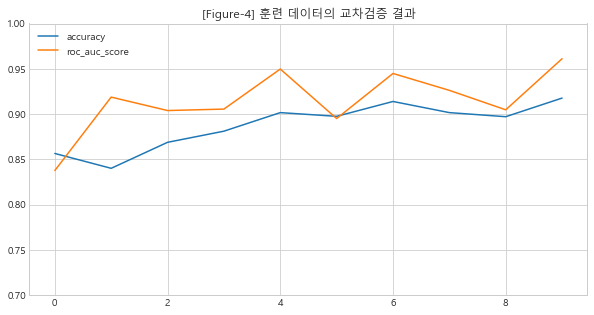

In [61]:
plt.plot( accuracy , label='accuracy')
# plt.plot( precision , label='precision')
# plt.plot( recall_score , label='recall_score')
# plt.plot( f1_score , label='f1_score')
plt.ylim(0.7,1.0)
plt.plot( roc_auc_score , label='roc_auc_score')
plt.legend()
plt.title( '[Figure-4] 훈련 데이터의 교차검증 결과')
plt.show()

In [62]:
best_model.predict_proba(X_test).shape

(1046, 2)

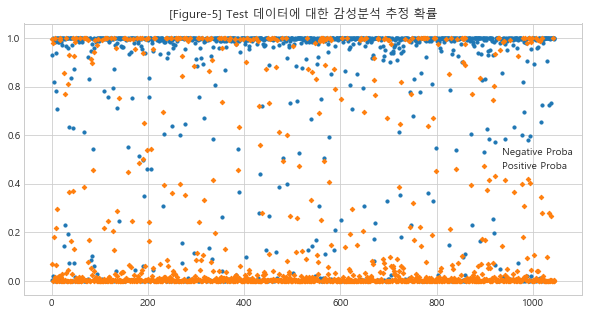

In [63]:
proba_0 = best_model.predict_proba(X_test)[:,0]
proba_1 = best_model.predict_proba(X_test)[:,1]

plt.scatter( range(len(proba_0)), proba_0, label='Negative Proba', s=10 )
plt.scatter( range(len(proba_0)), proba_1, label='Positive Proba', s=10, marker='D' )
plt.title('[Figure-5] Test 데이터에 대한 감성분석 추정 확률')
plt.legend()
plt.show()

## 7. 모델2를 거친 데이터를 이용해 감성분석

In [34]:
df = pd.read_csv( 'data/취합_0407_1628_model2를 통한 후보자 예측 포함.csv', index_col=0 )
df

,date,press,area,party,party_eval,candidate,candidate_eval,title_comment,area_candidate
0,2021-03-12 19:13:00,조선일보,NaN,NaN,NaN,NaN,NaN,재보궐 부산 김영춘 박형준 서울도 양자 대결 철수야 뜸 들이지 말고 애국하는 마...,오세훈
1,2021-03-07 14:02:00,조선일보,2.0,1.0,0.0,NaN,NaN,재보궐 부산 김영춘 박형준 서울도 양자 대결 부산은오거돈선거이고 오거돈치부선거아...,오세훈
2,2021-03-07 13:15:00,조선일보,NaN,1.0,0.0,NaN,NaN,재보궐 부산 김영춘 박형준 서울도 양자 대결 일단 일자리와 경제를 말아드신 여당...,오세훈
3,2021-03-07 12:05:00,조선일보,NaN,NaN,NaN,NaN,NaN,재보궐 부산 김영춘 박형준 서울도 양자 대결 어떻게든 문재인 정권 졸개들 박살 ...,오세훈
4,2021-03-07 10:33:00,조선일보,NaN,NaN,NaN,NaN,NaN,재보궐 부산 김영춘 박형준 서울도 양자 대결 좌파 당선 도우미 안철수가 과연,오세훈
...,...,...,...,...,...,...,...,...,...
86138,2021-01-17 10:52:00,경향신문,NaN,NaN,NaN,NaN,NaN,홍준표 김종인 이제 사감 접을 때 빅 모두 포용해야 김종인 무슨 생각인가 나라를 먼...,기타
86139,2021-01-06 11:55:00,경향신문,NaN,NaN,NaN,NaN,NaN,안철수에 끌려다닐라거물 소환한 국민의힘 거물이라길래 클릭했더니 뭐냐 이건,기타
86140,2021-01-11 16:06:00,경향신문,NaN,NaN,NaN,NaN,NaN,서울특별시를 해체하는 시장이 되겠다 권수정 서울시의원 일 출마선언 부정어를 사용해서...,기타
86141,2021-01-13 10:06:00,경향신문,NaN,NaN,NaN,NaN,NaN,흑백 민주주의보수와 친여 채널 사이에 교집합은 없다아시타비는 돈이 되니까 공론의 장...,기타


In [35]:
df['title_comment']

0        재보궐  부산 김영춘  박형준 서울도 양자 대결 철수야 뜸 들이지 말고 애국하는 마...
1        재보궐  부산 김영춘  박형준 서울도 양자 대결 부산은오거돈선거이고 오거돈치부선거아...
2        재보궐  부산 김영춘  박형준 서울도 양자 대결 일단 일자리와 경제를 말아드신 여당...
3        재보궐  부산 김영춘  박형준 서울도 양자 대결 어떻게든 문재인 정권 졸개들 박살 ...
4             재보궐  부산 김영춘  박형준 서울도 양자 대결 좌파 당선 도우미 안철수가 과연
                               ...                        
86138    홍준표 김종인 이제 사감 접을 때 빅 모두 포용해야 김종인 무슨 생각인가 나라를 먼...
86139             안철수에 끌려다닐라거물 소환한 국민의힘 거물이라길래 클릭했더니 뭐냐 이건
86140    서울특별시를 해체하는 시장이 되겠다 권수정 서울시의원 일 출마선언 부정어를 사용해서...
86141    흑백 민주주의보수와 친여 채널 사이에 교집합은 없다아시타비는 돈이 되니까 공론의 장...
86142             오세훈 안철수에 입당 촉구 안하면 내가 출마 출마를 해나창한테 혼날라고 
Name: title_comment, Length: 86143, dtype: object

## 1. 후보자명/당명을 제거하지 않고 학습한 모델

In [36]:
# 감성분석 모델 불러오기
with open('model/pos_neg_logi_model_0405.dat', 'rb') as fp:
    new_model = pickle.load(fp)
print('출력 완료')

출력 완료


In [45]:
# Tf-Idf Vectorizer 불러오기
with open('model/tfidf_vectorizer_0405.dat', 'rb') as fp:
    new_tfidf_vectorizer = pickle.load(fp)
print('출력 완료')

출력 완료


### 예측하기

In [38]:
total_X = df['title_comment']

In [47]:
# CounterVectorrizer는 다시 fit시키는 것이 아니라 transform만 시키는 것
X = index_vectorizer.transform(total_X.to_list())

# tf-idf는 새로 생성하는 것이 아니라 학습시킨 td-idf를 저장하여 사용하는 것
X = new_tfidf_vectorizer.transform(X)

y_pred = new_model.predict(X)
y_pred

array([0., 0., 0., ..., 0., 0., 0.])

In [49]:
y_pred

array([0., 0., 0., ..., 0., 0., 0.])

### 후보별 예측 긍정/부정률 확인하기

In [50]:
target_df = df[['title_comment','area_candidate']]
target_df['pred_sentiment'] = y_pred

In [51]:
a = target_df.groupby('area_candidate').mean().loc[['박영선','오세훈','김영춘','박형준']]
a['pred_sentiment']

area_candidate
박영선    0.028769
오세훈    0.101293
김영춘    0.009043
박형준    0.020979
Name: pred_sentiment, dtype: float64

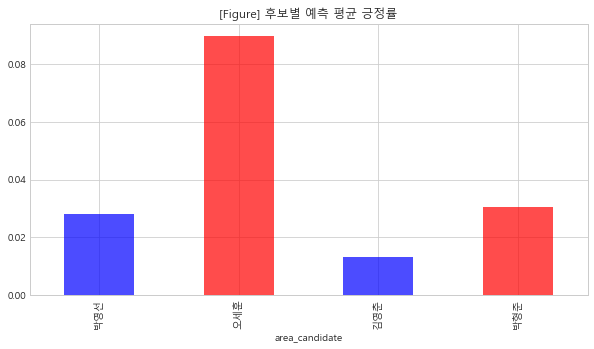

In [67]:
a['pred_sentiment'].plot(kind='bar', color=['b','r','b','r'], alpha=0.7)
plt.title('[Figure] 후보별 예측 평균 긍정률')
plt.show()

## 2. 후보자명/당명을 제거하고 학습한 모델

In [82]:
# 감성분석 모델 불러오기
with open('model/pos_neg_logi_model2_0405.dat', 'rb') as fp:
    new_model = pickle.load(fp)
print('출력 완료')

출력 완료


In [54]:
# Tf-Idf Vectorizer 불러오기
with open('model/tfidf_vectorizer2_0405.dat', 'rb') as fp:
    new_tfidf_vectorizer = pickle.load(fp)
print('출력 완료')

출력 완료


### 예측하기

In [55]:
total_X2 = df['title_comment']

In [59]:
# CounterVectorrizer는 다시 fit시키는 것이 아니라 transform만 시키는 것
X2 = index_vectorizer2.transform(total_X2.to_list())

# tf-idf는 새로 생성하는 것이 아니라 학습시킨 td-idf를 저장하여 사용하는 것
X2 = new_tfidf_vectorizer.transform(X2)

y_pred2 = new_model.predict(X2)
y_pred2

array([0., 0., 0., ..., 0., 0., 0.])

In [61]:
target_df2 = df[['title_comment','area_candidate']]
target_df2['pred_sentiment'] = y_pred2

In [62]:
a = target_df2.groupby('area_candidate').mean().loc[['박영선','오세훈','김영춘','박형준']]
a['pred_sentiment']

area_candidate
박영선    0.028218
오세훈    0.089486
김영춘    0.013408
박형준    0.030662
Name: pred_sentiment, dtype: float64

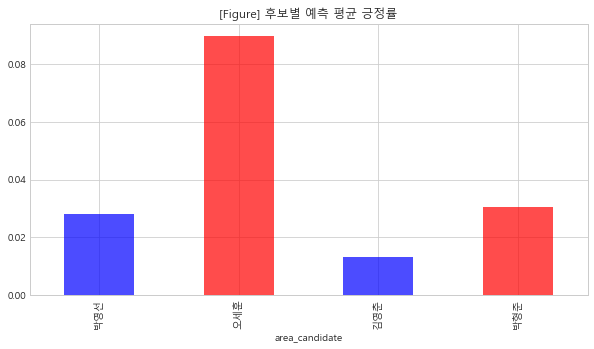

In [64]:
a['pred_sentiment'].plot(kind='bar', color=['b','r','b','r'], alpha=0.7)
plt.title('[Figure] 후보별 예측 평균 긍정률')
plt.show()

## 8. 부정단어 추출

In [141]:
# (단어인덱스, 회귀 계수) 형태로 만들기
tmp = list(enumerate(new_model.coef_[0]))
# display(tmp)

In [142]:
# (회귀계수, 인덱스) 형태인 튜플 생성
tmp2 = ( (value, index) for index, value in tmp)
tmp2

<generator object <genexpr> at 0x000002A591288F48>

In [143]:
# 오름차순 정렬: 회귀계수가 가장 높은 것부터 출력
coef_pos_index = sorted(tmp2, reverse=True) 
# coef_pos_index # 결과적으로 중요도 나타냄

## 긍정/부정 단어 확인
- 단어 사전 변형하기
    - { 단어: 단어 인덱스}에서 { 단어 인덱스: 단어 } 형태로 변형
- 긍정 단어 20개, 부정 단어 20개 파악

In [100]:
index_vectorizer.vocabulary_ # {단어: 인덱스, ...} 딕셔너리
index_vectorizer.vocabulary_.items() #  [ (단어: 인덱스), ..] 형태

# 단어 사전
word_dict={}

for pos, index in index_vectorizer.vocabulary_.items():
    # print(pos)
    word_dict[index] = pos
    
word_dict

{12742: '재보궐/Noun',
 7437: '부산/Noun',
 1865: '김영춘/Noun',
 6577: '박형준/Noun',
 8496: '서울/Noun',
 10305: '양자/Noun',
 3536: '대결/Noun',
 10962: '오거돈/Noun',
 8530: '선거/Noun',
 14872: '치부/Noun',
 9658: '아닌가/Adjective',
 8629: '성/Noun',
 14732: '추해으로/Adjective',
 8433: '생긴/Verb',
 137: '가독/Noun',
 9186: '신/Modifier',
 1141: '공항/Noun',
 12745: '재산/Noun',
 7602: '불려줄려고/Verb',
 6104: '문재인/Noun',
 6316: '민주당/Noun',
 4452: '들/Suffix',
 6706: '발악/Noun',
 9659: '아닌가다/Adjective',
 8109: '사람/Noun',
 15770: '하는말/Verb',
 11842: '이번/Noun',
 9459: '쎄/Adjective',
 7851: '빠지게/Verb',
 11464: '위/Noun',
 8529: '선가아이가다/Verb',
 12071: '일단/Noun',
 12131: '일자리/Noun',
 913: '경제/Noun',
 5301: '말/Noun',
 4419: '드신/Verb',
 10738: '여당/Noun',
 7869: '빼고/Verb',
 13717: '지/Verb',
 4453: '들/Verb',
 8644: '성범죄/Noun',
 15764: '하는데/Verb',
 8528: '선/Noun',
 202: '가비/Noun',
 15180: '토안/Noun',
 15726: '하는/Verb',
 7708: '비/Noun',
 10303: '양심/Noun',
 13042: '정당/Noun',
 3222: '님/Suffix',
 8902: '수십조/Modifier',
 8681: '세금/Noun',
 154

In [101]:
coef_pos_text = []

for value, index in coef_pos_index:
    # 각 인덱스에 해당하는 실제 단어 확인
    # print(word_dict[index])
    # print(value) # 회귀계수
    coef_pos_text.append( ( value, word_dict[index]) )
    
coef_pos_text

[(44.32110103672446, '오세훈/Noun'),
 (29.997818472779368, '화이팅/Noun'),
 (25.287109208580073, '승리/Noun'),
 (22.13950562933511, '승자/Noun'),
 (20.692732714273415, '믿고싶은/Verb'),
 (18.178762709154412, '보자/Verb'),
 (16.330736238631577, '필승/Noun'),
 (15.821111598658526, '승/Noun'),
 (15.31064989265092, '합니다/Verb'),
 (14.886547729268472, '윈/Noun'),
 (14.817600922753911, '님/Suffix'),
 (13.552239186117692, '선관위/Noun'),
 (13.334794468371673, '시장님/Noun'),
 (12.78507945907099, '세훈/Noun'),
 (12.728322329264252, '뽑을거야/Verb'),
 (12.192808825176678, '당선/Noun'),
 (11.833389145638563, '걱정/Noun'),
 (11.588928382287184, '독주/Noun'),
 (11.532166956617576, '번/Noun'),
 (11.25320867550675, '공/Modifier'),
 (11.214609275440155, '파이팅/Noun'),
 (11.196056842184635, '죽어라/Verb'),
 (11.172169550350455, '이긴다/Verb'),
 (11.16060767537871, '잘/VerbPrefix'),
 (11.057763165407062, '일주일/Noun'),
 (10.918179171004258, '입니다/Adjective'),
 (10.910397796570491, '가져라/Verb'),
 (10.874619025886066, '서치/Noun'),
 (10.815309531643264, '후보/No

In [131]:
# 회귀 계수가 높은 순으로 형용사들을 리스트에 담는다.
adj_list_by_coef = []
for i in coef_pos_text:
    if i[1].split('/')[1] == 'Adjective':
        adj_list_by_coef.append((float(i[0]),i[1].split('/')[0]))

In [150]:
adj_list_by_coef

[(10.918179171004258, '입니다'),
 (8.380653740134667, '있다'),
 (8.21453468416465, '애매해도'),
 (7.76189570029136, '유리하다'),
 (7.758297197086768, '있다는것이다'),
 (7.514983872134393, '안되면'),
 (7.359530035378347, '성실하고'),
 (6.724386244306955, '처절한'),
 (6.467600588063718, '강하다'),
 (6.373399133579972, '꼼꼼하게'),
 (6.366187775560746, '없으면'),
 (6.170825854096242, '대단한게'),
 (5.897145388190407, '확실하네'),
 (5.88937716566877, '용할'),
 (5.680210675620509, '아니잖어'),
 (5.680210675620509, '깨끗하지요'),
 (5.611077969564651, '없는게'),
 (5.594821971772368, '좋네요'),
 (5.574071943018738, '대단하다'),
 (5.5494100692663215, '철저하게'),
 (5.543351386807517, '안되는'),
 (5.4324669861072055, '꿋꿋한'),
 (5.377497139934033, '간단하게'),
 (5.34685811716025, '진정한'),
 (5.220364567957402, '유리한'),
 (5.090022888731575, '있는'),
 (5.042317175191112, '아름다운'),
 (5.034195781074115, '좋은'),
 (4.987302317930092, '많아'),
 (4.959230963236422, '작작해라'),
 (4.812819972169743, '든든합니다'),
 (4.711228690128907, '어떤'),
 (4.60802396114749, '나쁘진'),
 (4.422378651257692, '신중하게'),
 (

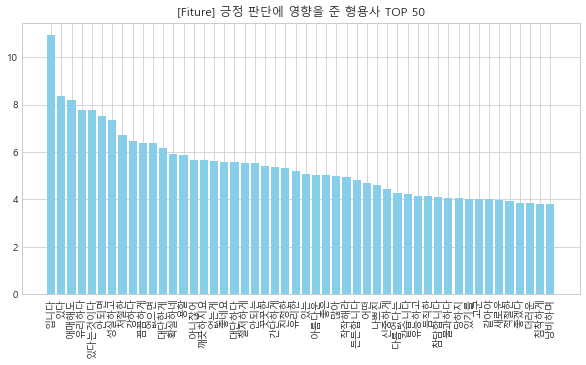

In [149]:
# 긍정 판단에 영향을 주는 형용사 top 50
np.array(adj_list_by_coef[:50])[:,1]

plt.bar( np.array(adj_list_by_coef[:50])[:,1],
         np.array(adj_list_by_coef[:50])[:,0].astype(float), color='skyblue')
plt.title('[Fiture] 긍정 판단에 영향을 준 형용사 TOP 50')
plt.xticks(rotation=90)
plt.show()

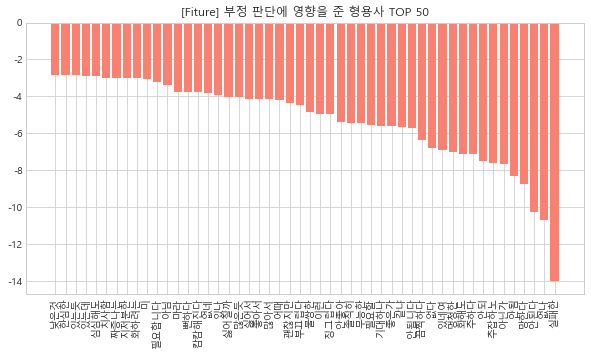

In [147]:
# 부정 판단에 영향을 주는 형용사 top 50
np.array(adj_list_by_coef[-50:])[:,1]

plt.bar( np.array(adj_list_by_coef[-50:])[:,1],
         np.array(adj_list_by_coef[-50:])[:,0].astype(float), color='salmon')
plt.title('[Fiture] 부정 판단에 영향을 준 형용사 TOP 50')
plt.xticks(rotation=90)
plt.show()

In [104]:
adj_list_by_coef

import pickle

# 리스트를 저장
with open('data/adj_list_by_model1.pickle', 'wb') as f:
    pickle.dump(adj_list_by_coef, f, pickle.HIGHEST_PROTOCOL)